# 프로젝트3 : 카메라 스티커앱 만들기 첫걸음

(1) 얼굴인식 카메라의 흐름

  얼굴이 포함된 사진 준비 -> 얼굴의 bounding box 찾기 -> 눈, 코, 입, 귀 등의 landmark 찾기 -> 찾아진 영역으로 부터 원하는 스티커 부착
  

(2) dlib 라이브러리란?   
  이미지 처리, 선형대수 뿐만 아니라 다양한 머신러닝 알고리즘을 활용할 수 있는 라이브러리로, 특히 HOG(Histogram of Oriented Gradients) 특성을 사용하여 얼굴 검출하는 기능이 많이 사용되고 소개된다.



---

## 목차

1. 사진 준비
2. 얼굴 검출 face detection
3. 얼굴 랜드마크 face landmark
4. 스티커 적용하기
5. 여러 종류의 이미지 테스트
6. 회고   
  <1> 매우 밝은 얼굴 이미지   
  <2> 대비가 낮은 흑백 사진   
  <3> 여러 명인 사진   
  <4> 옆 모습 사진   
  <5> 기존 사진 재실험   
  <6> 얼굴 일부가 가려진 사진   
  <7> 얼굴 전체가 담기지 않은 사진

###**1. 사진 준비**

디렉토리 생성

In [1]:
! mkdir project3
! mkdir project3/model
! ls

project3  sample_data


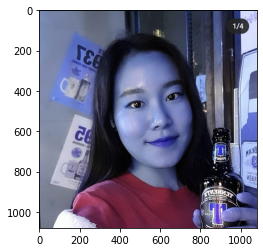

In [2]:
#찾은 이미지 출력

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

my_image_path = '/content/project3/image/selfie.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

❗ pencv는 BGR(파랑, 녹색, 빨강)을 사용하기 때문에 원본의 빨간색이 파란색으로, 원본의 파란색이 빨간색으로 반전되어 나온다.

따라서 다른 이미지 라이브러리에서 사용하기 위해서는 색 보정처리가 필요하다.

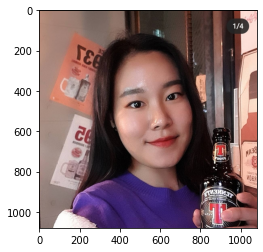

In [3]:
#이미지 색상 복구
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

❗ detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 

### **2. 얼굴 검출 face detection**

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴 찾기

이때 HOG는 이미지에서 색상의 변화량을 나타낸 것

In [4]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

# detector_hog를 이용해서 얼굴의 bounding box를 추출
# dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해 bgr을 rgb로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸
🌫🛸


detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 

이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.

이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능

rectangles[[(348, 297) (810, 759)]]


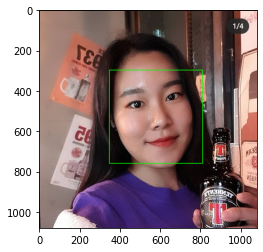

In [5]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함

### **3. 얼굴 랜드마크 face landmark**   

이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 함

<img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png" width="" height=""  title="px(픽셀) 크기 설정" alt="랜드마크"></img><br/>
[Dlib에 사용 되는 랜드마크 순서]   

- Object keypoint estimation 알고리즘이란?   
Face landmark와 같이 객체 내부의 점을 찾는 기술을 말한다.   
keypoint를 찾는 알고리즘은 크게 2가지로 나누어진다.   
  - top-down : bounding box를 찾고 box 내부의 keypoint를 예측 => 이 방식을 사용해서 스티커 붙일 예정   
  - bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

---


 weight file 다운받기

In [8]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! ls
! cp ./shape_predictor_68_face_landmarks.dat.bz2 ./project3/model/
! bzip2 -d /content/project3/model/shape_predictor_68_face_landmarks.dat.bz2

--2022-01-18 08:05:22--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  42.0MB/s    in 1.5s    

2022-01-18 08:05:24 (42.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

project3  sample_data  shape_predictor_68_face_landmarks.dat.bz2


In [9]:
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


❗ landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

In [10]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


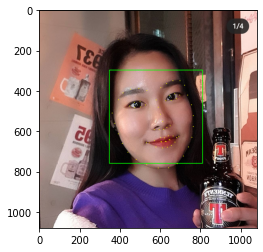

In [11]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### **4. 스티커 적용하기**

In [12]:
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(612, 552)
(x,y) : (612,321)
(w,h) : (463,463)


(463, 463, 3)


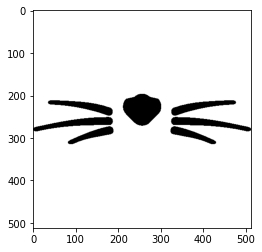

In [14]:
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

In [15]:
#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y    #위 아래 위치를 조절해줌
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (381,321)


In [16]:
#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (381,321)


슝~


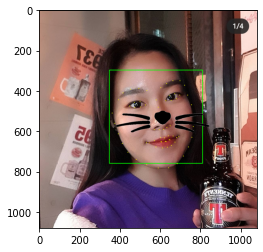

In [17]:
#스티커 적용 후 출력
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)    # 이 조건을 바꿔줌 , 어려운 부분이군.. 동섭님은 img_sticker!=0 이렇게 하셨다고 함
print("슝~")

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### **5. 여러 종류의 이미지 테스트**
<1> 매우 밝은 얼굴 이미지

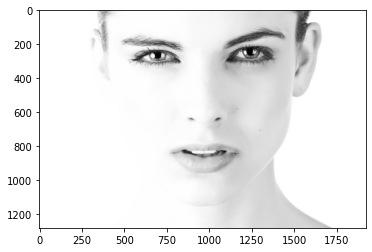

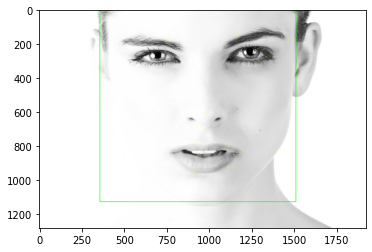

(984, 604)


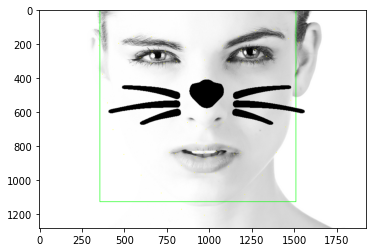

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#(1) 이미지 가져오기
my_image_path = '/content/project3/image/woman.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    #이미지 색상 복구 BGR ->RGB
plt.imshow(img_rgb)
plt.show()

#(2) 얼굴 검출하기
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언
dlib_rects = detector_hog(img_rgb, 1)   #얼굴의 bounding box를 추출

# 찾은 얼굴 영역의 박스 표시

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

#(3) 얼굴 랜드마크 face landmark
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#(4) 스티커 적용하기
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()

#스티커 이미지 불러오기 및 리사이즈
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))

#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y 

#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

#스티커 이미지 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

<2> 대비가 낮은 흑백 사진

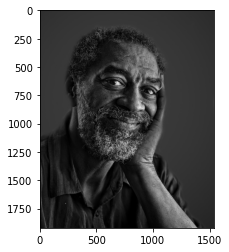

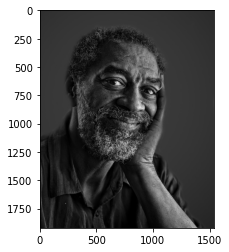

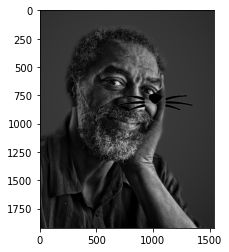

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#(1) 이미지 가져오기
my_image_path = '/content/project3/image/man.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    #이미지 색상 복구 BGR ->RGB
plt.imshow(img_rgb)
plt.show()

#(2) 얼굴 검출하기
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언
dlib_rects = detector_hog(img_rgb, 1)   #얼굴의 bounding box를 추출

# 찾은 얼굴 영역의 박스 표시

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

#(3) 얼굴 랜드마크 face landmark
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#(4) 스티커 적용하기
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()

#스티커 이미지 불러오기 및 리사이즈
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))

#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y 

#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

#스티커 이미지 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

<3> 여러 명인 사진

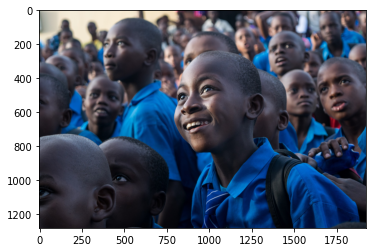

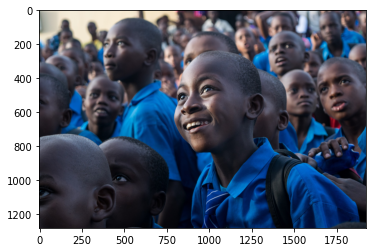

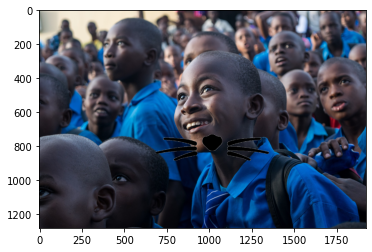

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#(1) 이미지 가져오기
my_image_path = '/content/project3/image/people.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    #이미지 색상 복구 BGR ->RGB
plt.imshow(img_rgb)
plt.show()

#(2) 얼굴 검출하기
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언
dlib_rects = detector_hog(img_rgb, 1)   #얼굴의 bounding box를 추출

# 찾은 얼굴 영역의 박스 표시

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

#(3) 얼굴 랜드마크 face landmark
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#(4) 스티커 적용하기
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()

#스티커 이미지 불러오기 및 리사이즈
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))

#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y 

#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

#스티커 이미지 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

<4> 옆 모습 사진

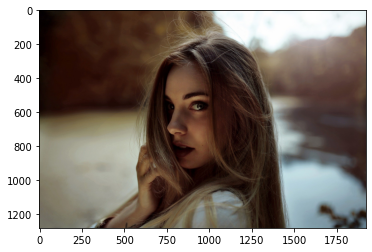

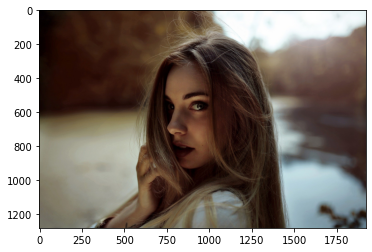

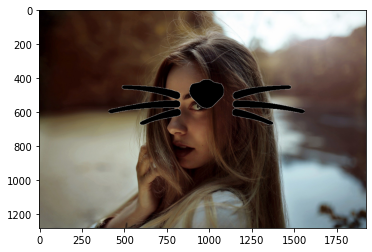

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#(1) 이미지 가져오기
my_image_path = '/content/project3/image/model.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    #이미지 색상 복구 BGR ->RGB
plt.imshow(img_rgb)
plt.show()

#(2) 얼굴 검출하기
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언
dlib_rects = detector_hog(img_rgb, 1)   #얼굴의 bounding box를 추출

# 찾은 얼굴 영역의 박스 표시

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

#(3) 얼굴 랜드마크 face landmark
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#(4) 스티커 적용하기
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()

#스티커 이미지 불러오기 및 리사이즈
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))

#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y 

#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

#스티커 이미지 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

<5> 기존 사진 재실험

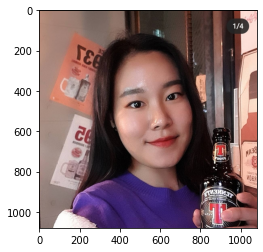

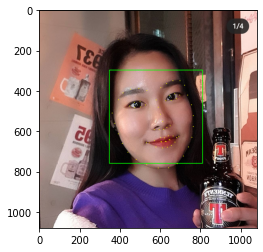

(612, 552)


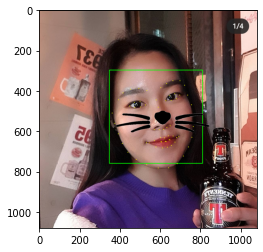

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#(1) 이미지 가져오기
my_image_path = '/content/project3/image/selfie.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    #이미지 색상 복구 BGR ->RGB
plt.imshow(img_rgb)
plt.show()

#(2) 얼굴 검출하기
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언
dlib_rects = detector_hog(img_rgb, 1)   #얼굴의 bounding box를 추출

# 찾은 얼굴 영역의 박스 표시

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

#(3) 얼굴 랜드마크 face landmark
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#(4) 스티커 적용하기
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()

#스티커 이미지 불러오기 및 리사이즈
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))

#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y 

#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

#스티커 이미지 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

<6> 얼굴 일부가 가려진 사진

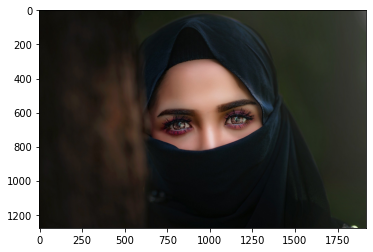

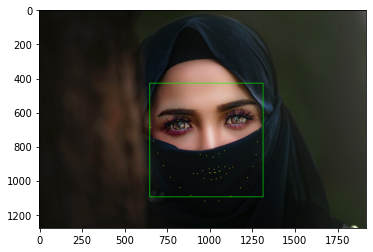

(1017, 807)


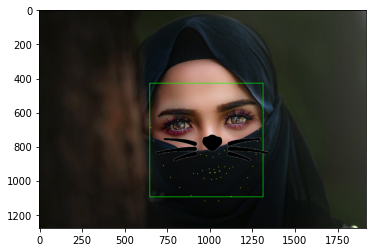

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#(1) 이미지 가져오기
my_image_path = '/content/project3/image/hijab.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    #이미지 색상 복구 BGR ->RGB
plt.imshow(img_rgb)
plt.show()

#(2) 얼굴 검출하기
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언
dlib_rects = detector_hog(img_rgb, 1)   #얼굴의 bounding box를 추출

# 찾은 얼굴 영역의 박스 표시

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

#(3) 얼굴 랜드마크 face landmark
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#(4) 스티커 적용하기
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()

#스티커 이미지 불러오기 및 리사이즈
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))

#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y 

#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

#스티커 이미지 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

<7> 얼굴 전체가 담기지 않은 사진

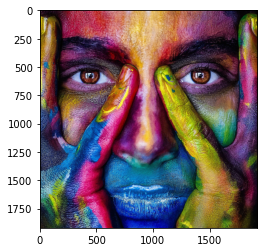

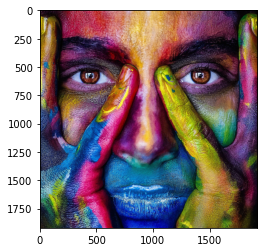

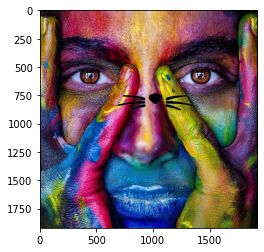

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#(1) 이미지 가져오기
my_image_path = '/content/project3/image/girl.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    #이미지 색상 복구 BGR ->RGB
plt.imshow(img_rgb)
plt.show()

#(2) 얼굴 검출하기
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언
dlib_rects = detector_hog(img_rgb, 1)   #얼굴의 bounding box를 추출

# 찾은 얼굴 영역의 박스 표시

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

#(3) 얼굴 랜드마크 face landmark
# 저장한 landmark 모델을 불러오기

model_path = '/content/project3/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#(4) 스티커 적용하기
#코 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()

#스티커 이미지 불러오기 및 리사이즈
sticker_path = '/content/project3/image/cat.png'
img_sticker = cv2.imread(sticker_path)
plt.imshow(img_sticker)
img_sticker = cv2.resize(img_sticker, (w,h))

#x, y 좌표 조절
refined_x = x - w // 2
refined_y = y 

#-크롭
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

#스티커 이미지 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## ***❗❗❗ 다양한 이미지 적용 결과***   
- 다양한 이미지에 적용을 시켜보니 생각보다 많은 사진들에서 얼굴을 인식 못한다는 점을 발견하였다.   
- 실제로 여러 카메라 어플을 사용해보면 얼굴이 멀어지거나 옆모습 또는 코와 입을 손으로 가리는 등의 변수를 주면 어플 스티커가 내 얼굴에 적용이 되지 않는다.   
 따라서 시중 카메라 어플을 생각하면 위 결과가 아주 나쁘다고는 생각하지 않는다.   

- 우선 <1>의 경우 사진의 노출이 심해 사실상 왼쪽 윤곽이 많이 날아간 사진이다.   
 따라서 나는 이 사진에서는 얼굴 인식을 못해 랜드마크를 만들어내지 못 할것이라고 예상했다.   
 나의 예상과는 다르게 스티커까지 매우 완벽하게 잘 적용된 사례다.

- <2>와 <3>은 전반적으로 확인해보면 사람의 피부톤과 배경의 톤 차이가 많이 나지않는 사진이다. 둘 다 사람 얼굴을 인식하지 못했고, 스티커는 아무데나 붙여졌다. 따라서 얼굴과 배경의 대비가 높은 사진이 인식하기 좋은 것 같다.   
- <4>는 옆모습으로 예상했던대로 얼굴 인식을 하지 못했다.   
- <5>는 <2><3><4> 사례에서 얼굴 인식을 하지 못했음에도 스티커가 특정 위치에 붙길래 처음에 진행했던 내 사진으로 다시 스티커를 붙인 후 <2> 을 진행해보았다.   
후순위에 진행되는 사례들 중 얼굴인식을 하지 못한 사진들은 앞서 진행된 스티커의 크기와 위치에 붙여지는 것을 발견하였다.   
- <6> 번은 얼굴 일부가 가려진 사진으로 의외를 결과가 나타나였다. 코까지 가려진 사진이라 당연히 인식하지 못할 줄 알았는데 얼굴 상단의 얼굴형와 눈의 위치가 뚜렷해 그 부분만으로 랜드마크가 붙어 자연스레 코의 위치가 유추되었다. 따라서 해당 사진도 스티커사진이 매우 잘 붙었다.
- 마지막 <7>을 통해 얼룩진 얼굴에 얼굴 형태를 가진 사진을 사용해보았다. 역시나 인식하지 못하였다. 최소한 얼굴형태 일부는 유추가 되어야지만 랜드마크를 붙일 수 있다는 사실을 알게 되었다.

- 위 결과를 통해 스티커가 잘 적용되기 위해서는 몇 가지 조건이 필요함을 알게 되었다.  
1. 얼굴색과 비슷한 배경이 아닌 얼굴 윤곽을 잘 드러내주는 배경일수록 인식률이 좋다.
2. 옆 모습 또는 얼굴형 전체를 가리면 얼굴 형태를 인식하지 못한다. 다만 특정 형태가 뚜렷하게 보이면 랜드마크를 통해 나머지 일부 신체부위 예측이 가능하다.<6>번 사진 참고
3. 여러 명의 사진에서 스티커를 붙이고 싶을 경우에는 모두가 명확한 사진이어야 모두 인식할 확률이 높다.


###**6. 회고**
(1) Open CV

컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리

이미지 딥러닝(알파고 기술)에도 많이 활용

이미지채널로  BGR(파랑, 녹색, 빨강)을 사용하기 때문에 opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색 보정처리가 필요함

(2) 컴퓨터 비전(Computer Vision)이란?

카메라, 에지 기반 또는 클라우드 기반 컴퓨팅, 소프트웨어 및 인공 지능(AI)을 결합하여 시스템이 사물을 "확인"하고 식별할 수 있게 함

(3)  np.where
 np.where(배열에 대한 조건문, 참일때 값, 거짓일때 값)의 형태로 사용
 https://yganalyst.github.io/data_handling/memo_3/

 (4) 스티커 사진의 회전   
  모든 사진이 정면을 바라보는 것이 아니기 때문에 스티커 사진이 얼굴의 각도에 맞게 조절되는 것도 필요하다.
  이 부분은 lms에 나와있지 않아 최대한 구글링을 해보았지만 배경지식이 부족하다보니 알맞은 검색 단어를 찾지 못했다. 이부분에 대해서도 한 번 다뤄주면 참 좋을 것 같다.